In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
"Setting up main Hyper-Parameters of the model"

n_qubits = 3  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
steps = 30  # Number of optimization steps
eta = 0.8  # Learning rate
q_delta = 0.001  # Initial spread of random quantum weights
rng_seed = 0  # Seed for random number generator


In [3]:
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 + c_2 A_2...
c = np.array([1.0, 0.2, 0.2])
#c = np.array([1.0,0.2,0.2,0.2])


In [4]:
def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        qml.CNOT(wires=[ancilla_idx, 0])
        qml.CZ(wires=[ancilla_idx, 1])

    elif idx == 2:
        qml.CNOT(wires=[ancilla_idx, 0])

In [5]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    
    # We first prepare an equal superposition of all the states of the computational basis.
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit.
    # just a single layer of qubit rotations around y
    # can make more complex 
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)
        
        
    # return qml.expval(qml.PauliZ(0)) 
    ## don't actually want to return anything, just there to visualize for now
      
weights = np.random.random(size=3)
drawer = qml.draw(variational_block)
#print(drawer(weights))

In [6]:
"Example of more complicated circuit using Pennylane StronglyEntaglingLayers, this is for later"
"Let's first get the RY circuit working"

dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(parameters):
    for idx in range(4):
        qml.Hadamard(wires=idx)
    
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(4))
    return qml.expval(qml.PauliZ(0))

shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
weights = np.random.random(size=shape)

print(qml.draw(circuit, expansion_strategy="device")(weights))

0: ──H──Rot(0.69,0.23,0.15)─╭●───────╭X──Rot(0.63,0.19,0.92)─╭●────╭X────┤  <Z>
1: ──H──Rot(0.56,0.27,0.41)─╰X─╭●────│───Rot(0.04,0.49,0.68)─│──╭●─│──╭X─┤     
2: ──H──Rot(0.88,0.54,0.31)────╰X─╭●─│───Rot(0.81,0.08,0.24)─╰X─│──╰●─│──┤     
3: ──H──Rot(0.42,0.68,0.72)───────╰X─╰●──Rot(0.57,0.24,0.00)────╰X────╰●─┤     


In [7]:
dev_mu = qml.device("default.qubit", wires=tot_qubits)

@qml.qnode(dev_mu)
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    # In this specific example Adjoint(U_b) = U_b.
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

In [8]:
print(qml.draw(local_hadamard_test)(weights=[1.2, 3.2, 0.7]))

   0: ──H──RY(1.20)──H──H─┤     
   1: ──H──RY(3.20)──H──H─┤     
   2: ──H──RY(0.70)──H──H─┤     
   3: ──H─╭●─────────H────┤  <Z>
None: ────╰Z──────────────┤     


In [9]:
def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

#### Local Cost Function
Need a function to estimate $<x|A^\dagger A|x>$

In [10]:
def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

In [11]:
def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

#### Variational Optimization

In [12]:
#Intialize the weights with a fix seed

np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits, requires_grad=True)

In [13]:
#classical optimizer to minimize the cost function

opt = qml.GradientDescentOptimizer(eta)
#opt = qml.jacobian(eta)
#opt - qml.elementwise_grad(eta)
#opt = qml.holomorphic_grad(eta)

In [14]:
cost_history = []
for it in range(steps):
    w, cost = opt.step_and_cost(cost_loc, w)
    print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
    cost_history.append(cost)

Step   0       Cost_L = 0.0089888
Step   1       Cost_L = 0.0070072
Step   2       Cost_L = 0.0054157
Step   3       Cost_L = 0.0041528
Step   4       Cost_L = 0.0031617
Step   5       Cost_L = 0.0023917
Step   6       Cost_L = 0.0017988
Step   7       Cost_L = 0.0013461
Step   8       Cost_L = 0.0010028
Step   9       Cost_L = 0.0007442
Step  10       Cost_L = 0.0005503
Step  11       Cost_L = 0.0004058
Step  12       Cost_L = 0.0002984
Step  13       Cost_L = 0.0002190
Step  14       Cost_L = 0.0001604
Step  15       Cost_L = 0.0001173
Step  16       Cost_L = 0.0000857
Step  17       Cost_L = 0.0000625
Step  18       Cost_L = 0.0000455
Step  19       Cost_L = 0.0000331
Step  20       Cost_L = 0.0000241
Step  21       Cost_L = 0.0000175
Step  22       Cost_L = 0.0000127
Step  23       Cost_L = 0.0000092
Step  24       Cost_L = 0.0000067
Step  25       Cost_L = 0.0000049
Step  26       Cost_L = 0.0000035
Step  27       Cost_L = 0.0000026
Step  28       Cost_L = 0.0000019
Step  29      

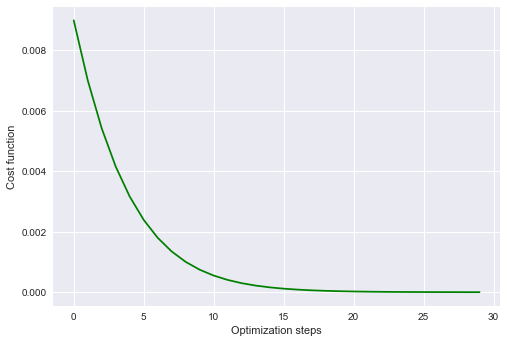

In [15]:
plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

#### Preparation of Quantum Solution

In [16]:
dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x)
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

In [17]:
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / n_shots


In [18]:
print("|<x|n>|^2=\n", q_probs)

|<x|n>|^2=
 [0.084589 0.085022 0.164642 0.164879 0.085241 0.084731 0.165431 0.165465]


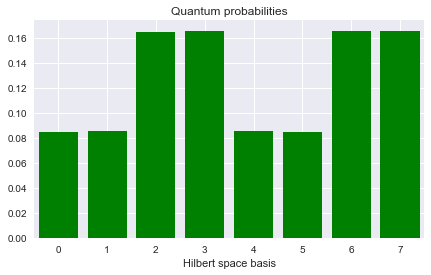

In [19]:
fig, ax2 = plt.subplots(1, figsize=(7, 4))

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()

In [20]:
Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.identity(8)
A_1 = np.kron(np.kron(X, Z), Id)
A_2 = np.kron(np.kron(X, Id), Id)

A = c[0] * A_0 + c[1] * A_1 + c[2] * A_2
b = np.ones(8) / np.sqrt(8)

In [21]:
A

tensor([[1. , 0. , 0. , 0. , 0.4, 0. , 0. , 0. ],
        [0. , 1. , 0. , 0. , 0. , 0.4, 0. , 0. ],
        [0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. ],
        [0.4, 0. , 0. , 0. , 1. , 0. , 0. , 0. ],
        [0. , 0.4, 0. , 0. , 0. , 1. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]], requires_grad=True)

In [22]:
from scipy.sparse.linalg import eigs

vals, vecs = eigs(Z)

/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1266: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


In [23]:
vecs[1].shape

(2,)

In [24]:
np.conjugate(vecs[0]).reshape(-1,1)

tensor([[1.],
        [0.]], requires_grad=True)

In [25]:
eigs(A_0)

(array([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]),
 array([[-0.38572857+0.j, -0.31653525+0.j,  0.11334529+0.j,
         -0.52822613+0.j, -0.64491508+0.j,  0.37272125+0.j],
        [ 0.44559807+0.j, -0.24290503+0.j,  0.25087507+0.j,
         -0.55911205+0.j,  0.15726904+0.j, -0.20051693+0.j],
        [-0.3467528 +0.j, -0.07138456+0.j, -0.40905768+0.j,
         -0.15786843+0.j,  0.01488331+0.j,  0.11838599+0.j],
        [ 0.65522628+0.j,  0.02894757+0.j, -0.11332394+0.j,
         -0.02854008+0.j, -0.30996295+0.j,  0.27816478+0.j],
        [-0.18025217+0.j,  0.34563585+0.j, -0.20495894+0.j,
         -0.55327822+0.j,  0.05747875+0.j, -0.44927868+0.j],
        [-0.01787984+0.j,  0.2315297 +0.j,  0.12445411+0.j,
          0.20082285+0.j, -0.65760243+0.j, -0.68373003+0.j],
        [ 0.25609428+0.j,  0.47315191+0.j, -0.72346299+0.j,
          0.07148543+0.j, -0.13712312+0.j,  0.08840163+0.j],
        [-0.06857132+0.j,  0.66175977+0.j,  0.40391626+0.j,
         -0.17628705+0.j,  0.092222

In [34]:
Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.identity(8)
A_1 = np.kron(np.kron(X, Z), Id)
A_2 = np.kron(np.kron(X, Id), Id)

A = c[0] * A_0 + c[1] * A_1 + c[2] * A_2

In [45]:
eig_A0 = np.linalg.eig(A_0)[1][0]

In [43]:
eig_A0[1][0]

tensor([1., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [47]:
eig_A0 * A * eig_A0.T

tensor([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]], requires_grad=True)

In [52]:
eig1 = np.array([1,0]).T

In [53]:
A_test = [[1, 1],[1, -1]]

In [58]:
np.matmul(eig1.T,np.matmul(A_test,eig1))

tensor(1, requires_grad=True)

In [26]:
A_2 = [[1, 1],[1, -1]]

In [28]:
b

tensor([0.35355339, 0.35355339, 0.35355339, 0.35355339, 0.35355339,
        0.35355339, 0.35355339, 0.35355339], requires_grad=True)

In [29]:
A_inv = np.linalg.inv(A)
x = np.dot(A_inv, b)

In [30]:
x

tensor([0.25253814, 0.25253814, 0.35355339, 0.35355339, 0.25253814,
        0.25253814, 0.35355339, 0.35355339], requires_grad=True)

In [31]:
c

tensor([1. , 0.2, 0.2], requires_grad=True)

In [32]:
e1 = np.array([1,0])